In [1]:
import sys, os
sys.path.append('../')

import tensorflow as tf 
import segmentation_models as sm

from MRIsegm.datagenerators import create_segmentation_generator
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss

from MRIsegm.graphics import show_dataset, plot_history, show_prediction

Segmentation Models: using `tf.keras` framework.


In [2]:
BACKBONE = 'efficientnetb1'

SEED = 666
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALIDATION = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 406
NUM_VALIDATION = 80

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')


In [3]:
data_gen_args_img = dict(rescale=1./255, rotation_range=5,horizontal_flip=True)
data_gen_args_mask = dict(rescale=1./255, rotation_range=5,horizontal_flip=True)

val_data_gen_args_img = dict(rescale=1./255)
val_data_gen_args_mask = dict(rescale=1./255)

In [4]:
train_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask)

Found 406 images belonging to 1 classes.
Found 406 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


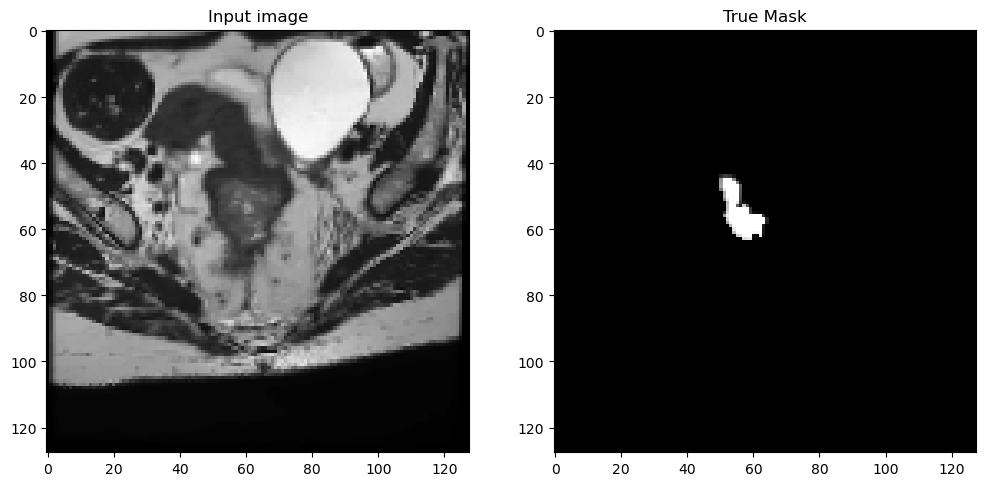

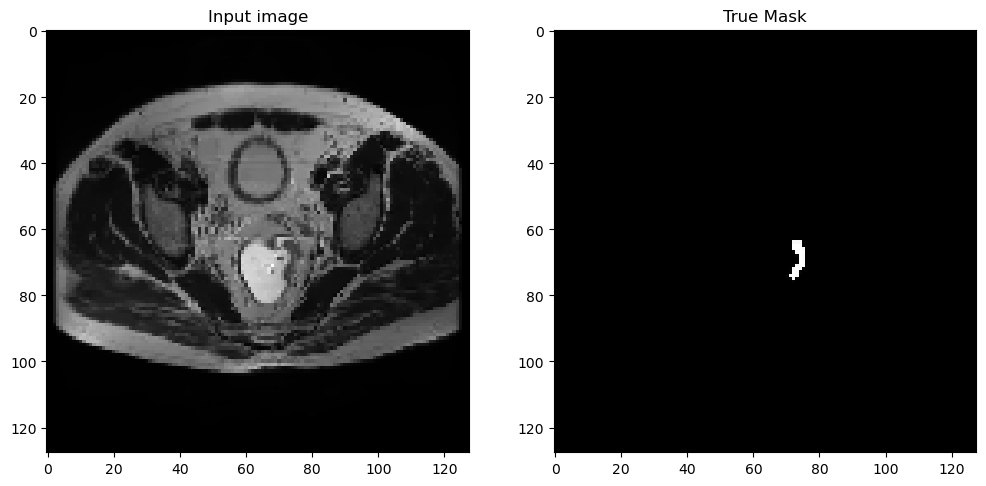

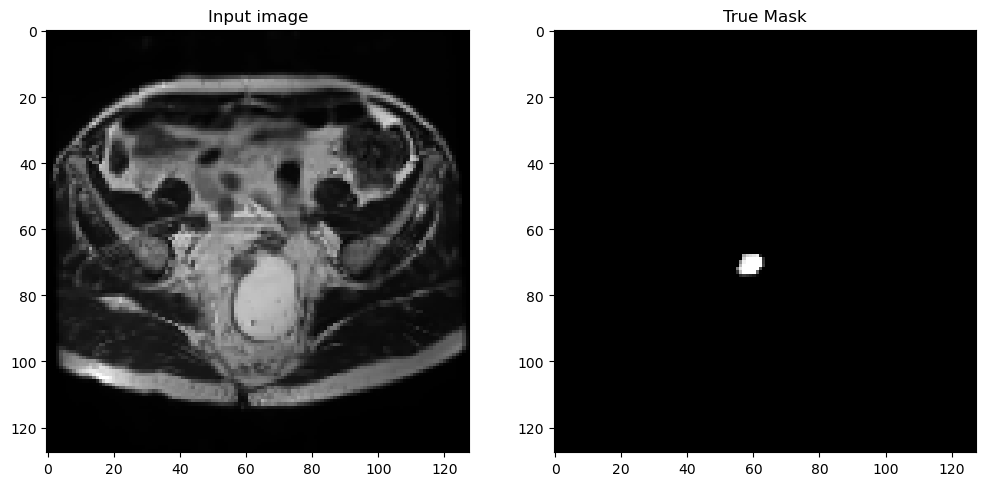

In [5]:
show_dataset(train_generator, 3) # training

In [6]:
model = sm.Unet(BACKBONE, input_shape=(128, 128, 1), encoder_weights=None, activation='sigmoid')

optimizer = 'Adam'
# iou_loss = sm.losses.JaccardLoss(class_weights=None, class_indexes=None, per_image=False, smooth=1.)
loss = DiceBCEloss
metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 32)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [7]:
model_name = BACKBONE + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}' 


if type(optimizer) == str: 
    model_name = model_name + f'_OPT={optimizer}' 
else:
    model_name = model_name + f'_OPT={optimizer._name}'


if type(loss) == str: 
    model_name = model_name + f'_LOSS={loss}' 
else:
    model_name = model_name + f'_LOSS={loss.__name__}'

print('model name: ', model_name)

model name:  efficientnetb1_128_128_OPT=Adam_LOSS=DiceBCEloss


In [8]:
#optional: logs_dir = '../data/models/logs/' + model_name

csv_dir = '../data/CSV/'

callbacks = [
                  tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  tf.keras.callbacks.CSVLogger( csv_dir + model_name + '.csv', separator=',', append=False),
                  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
                  #optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]


history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
101/101 [==============================] - 29s 253ms/step - loss: 1.2425 - dice_coef: 0.0477 - val_loss: 1.5290 - val_dice_coef: 0.0760
Epoch 2/100
101/101 [==============================] - 25s 244ms/step - loss: 0.7335 - dice_coef: 0.3106 - val_loss: 1.2721 - val_dice_coef: 0.1601
Epoch 3/100
101/101 [==============================] - 25s 245ms/step - loss: 0.6278 - dice_coef: 0.4138 - val_loss: 1.3734 - val_dice_coef: 0.1143
Epoch 4/100
101/101 [==============================] - 25s 245ms/step - loss: 0.5821 - dice_coef: 0.4577 - val_loss: 0.6856 - val_dice_coef: 0.3869
Epoch 5/100
101/101 [==============================] - 25s 245ms/step - loss: 0.5669 - dice_coef: 0.4700 - val_loss: 0.6209 - val_dice_coef: 0.4365
Epoch 6/100
101/101 [==============================] - 25s 244ms/step - loss: 0.5316 - dice_coef: 0.5008 - val_loss: 0.5392 - val_dice_coef: 0.5068
Epoch 7/100
101/101 [==============================] - 25s 244ms/step - loss: 0.5279 - dice_coef: 0.5076 - val_l

In [9]:
model.save('../data/models/' + model_name + '.h5')

In [10]:
#optional: %load_ext tensorboard

#optional: !tensorboard --logdir log_dir

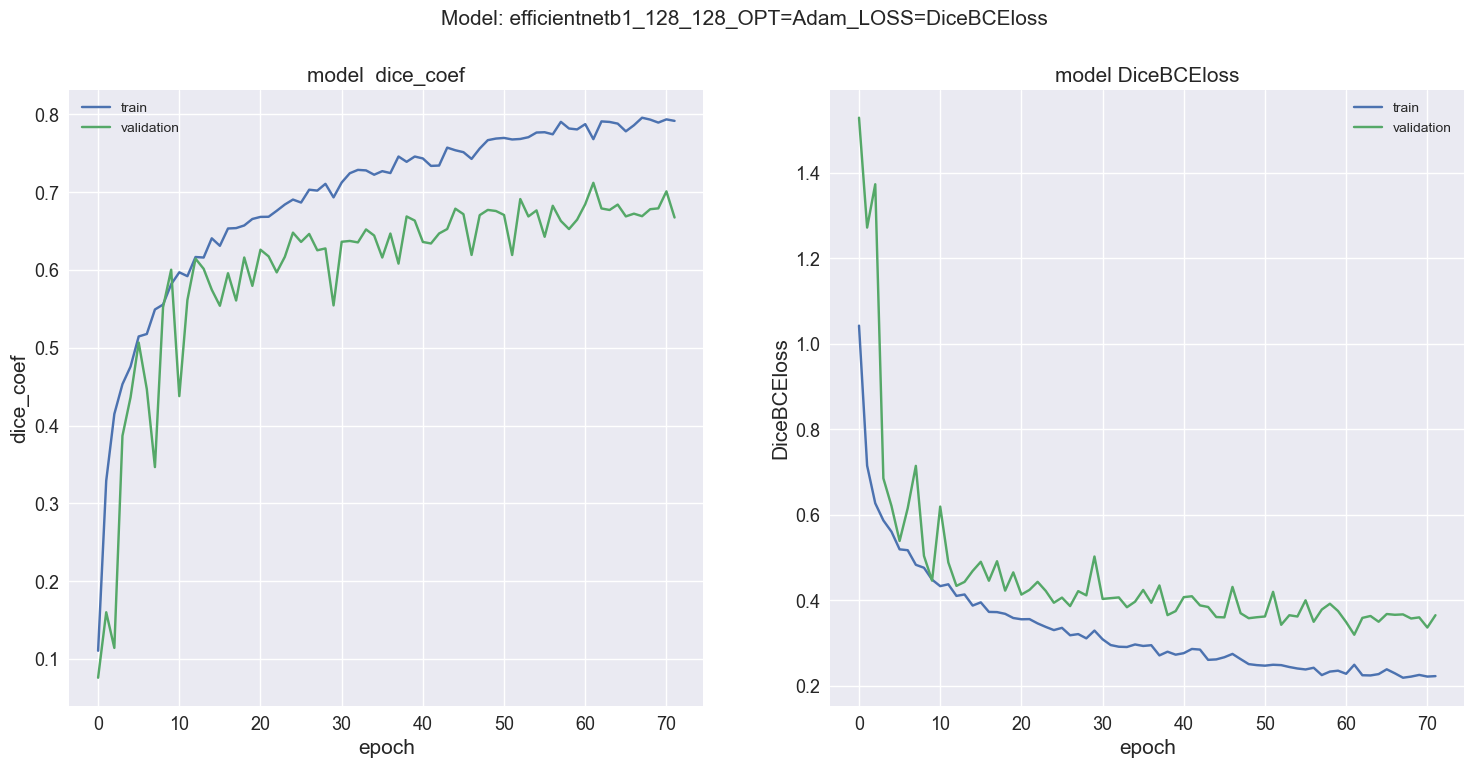

In [11]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, figsize=(18,8),labelsize=13, path='../data/plots/' + model_name)

In [12]:
print("Evaluating on validation data")
evaluation = model.evaluate(validation_generator, batch_size=BATCH_SIZE_VALIDATION, steps=EPOCH_STEP_VALIDATION, return_dict=True)
print(evaluation)

Evaluating on validation data
20/20 [==============================] - 1s 69ms/step - loss: 0.3467 - dice_coef: 0.6927
{'loss': 0.3466871380805969, 'dice_coef': 0.6927354335784912}


In [13]:
import json

with open('../data/evals/' + model_name + '_eval.txt', 'w') as file:
     file.write(json.dumps(evaluation))

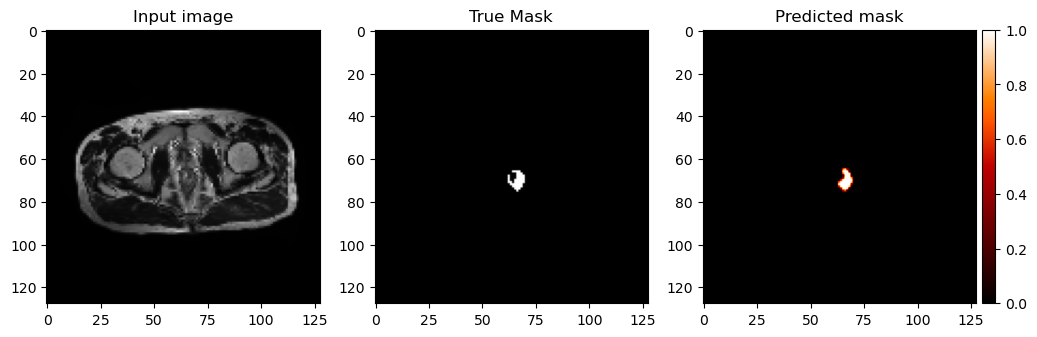

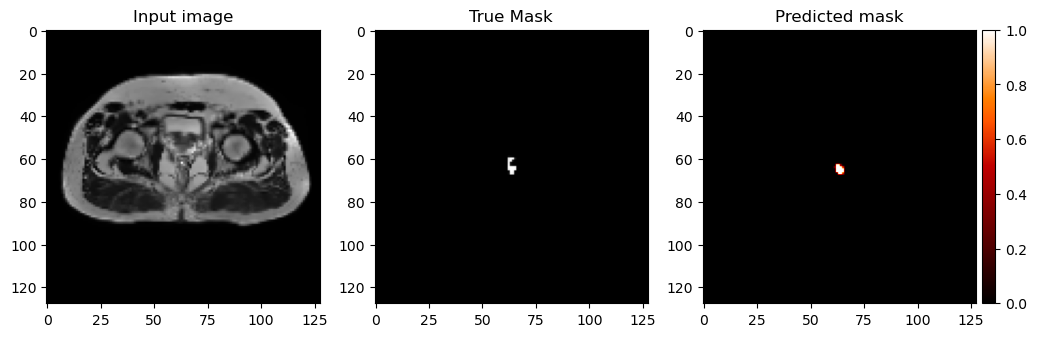

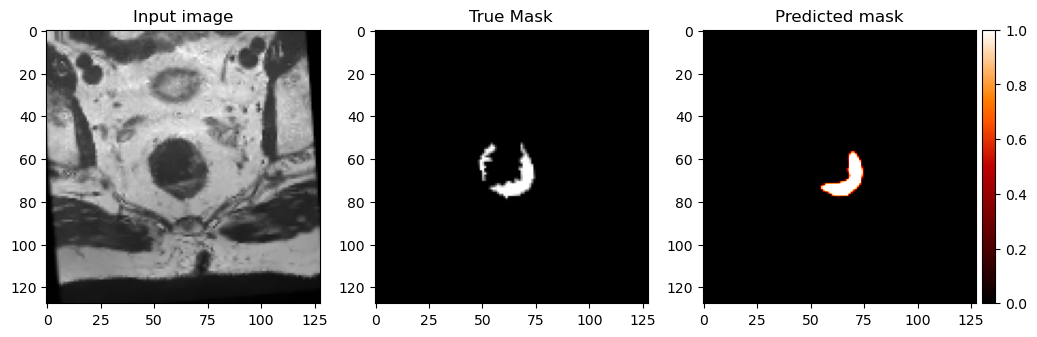

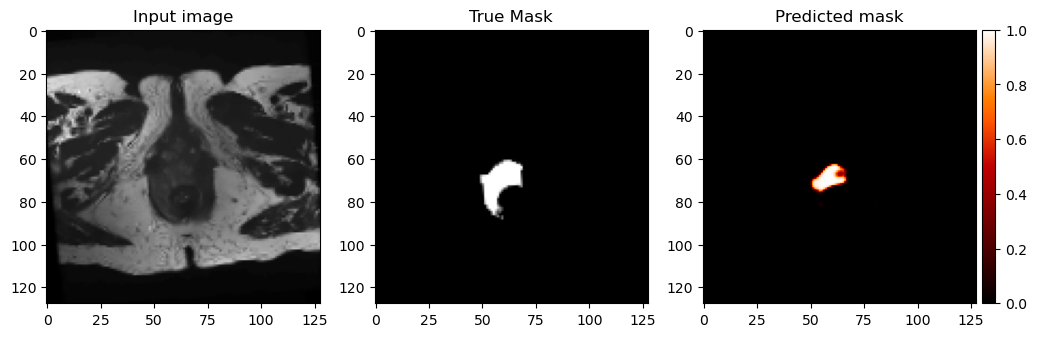

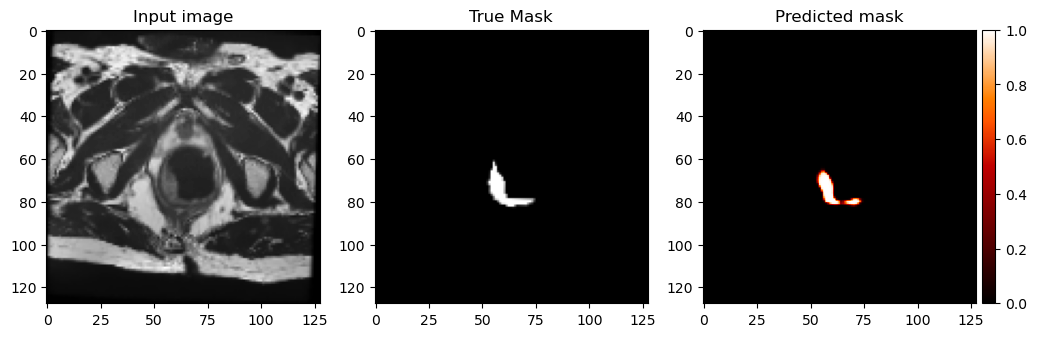

In [14]:
show_prediction(datagen=train_generator, model=model , num=5)

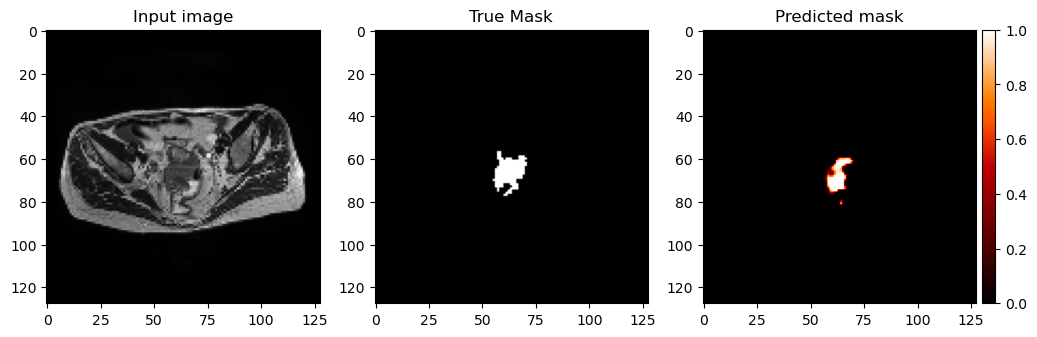

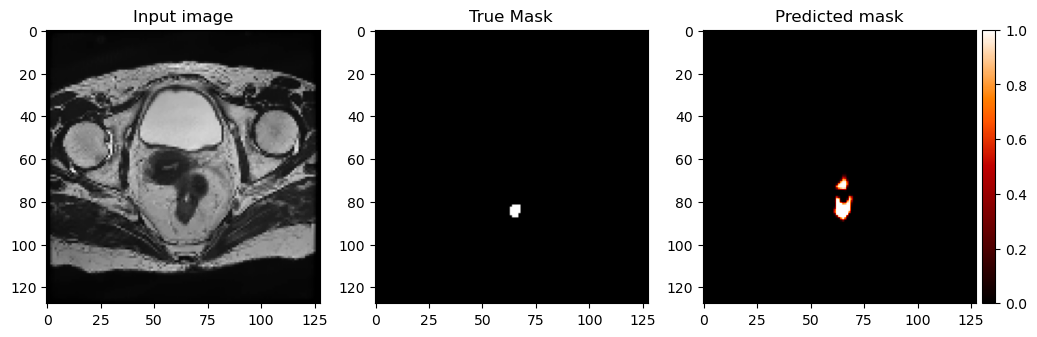

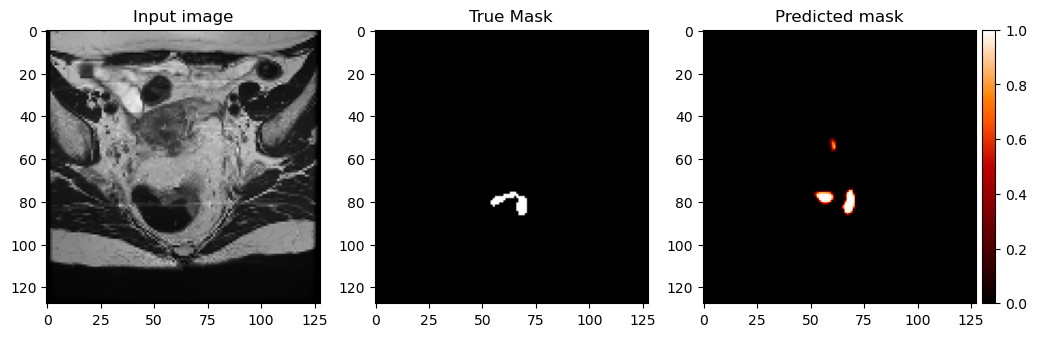

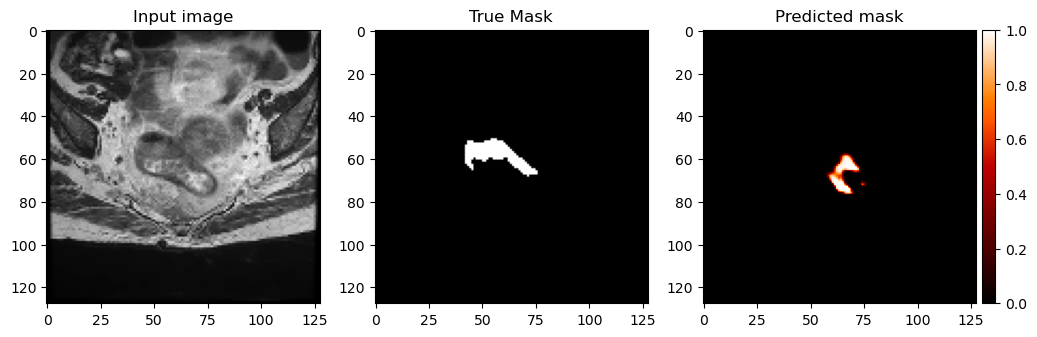

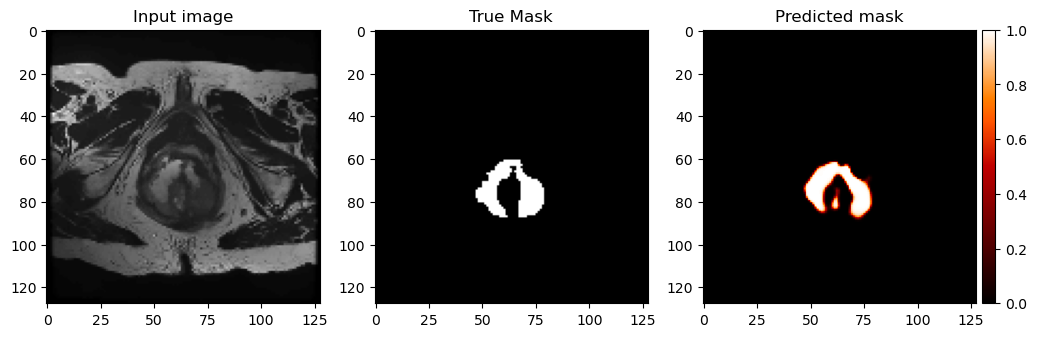

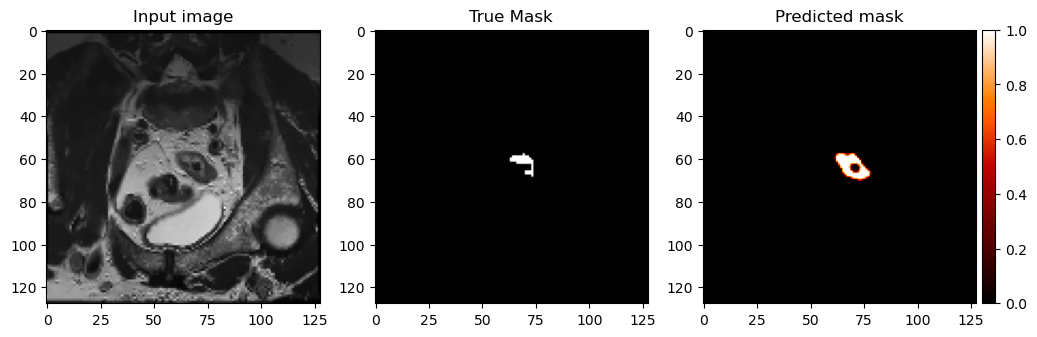

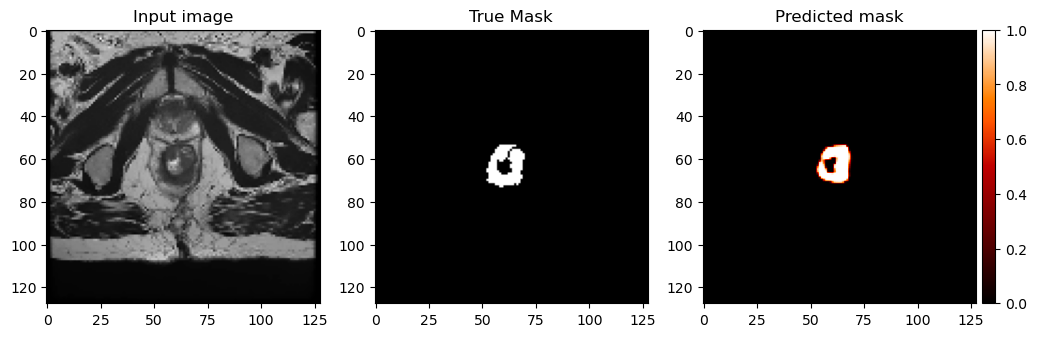

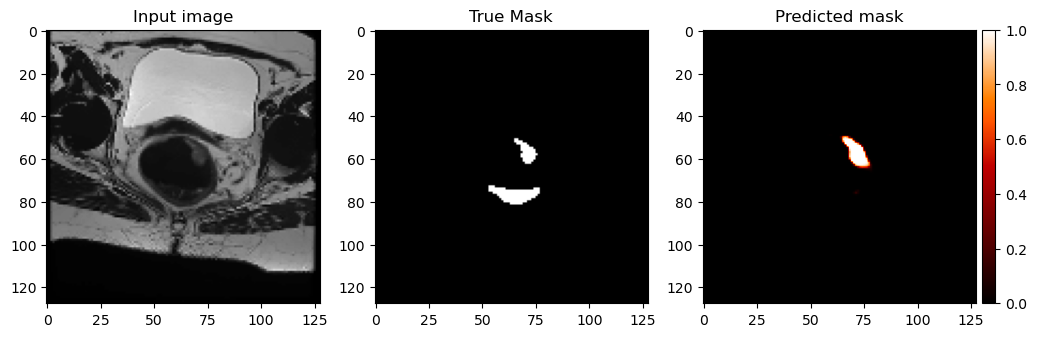

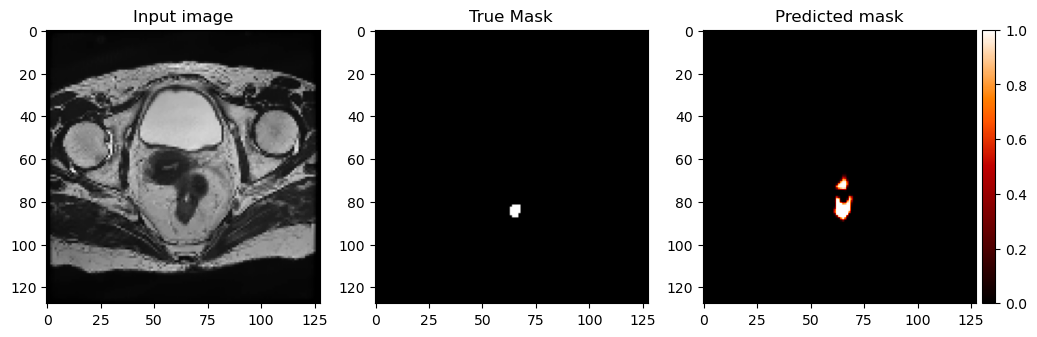

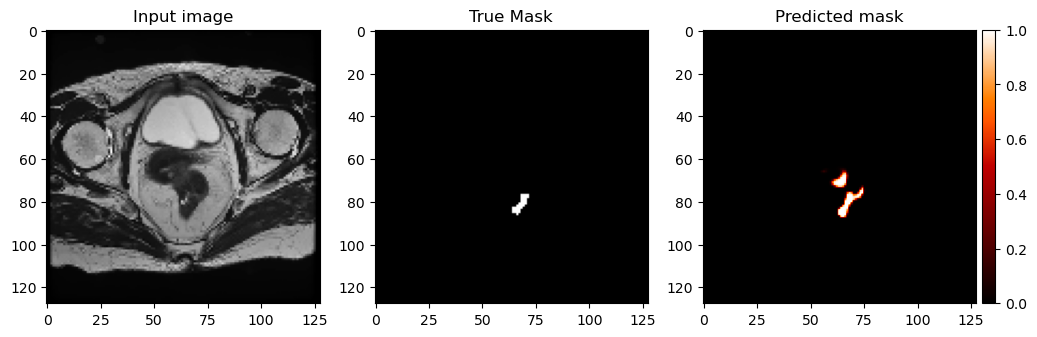

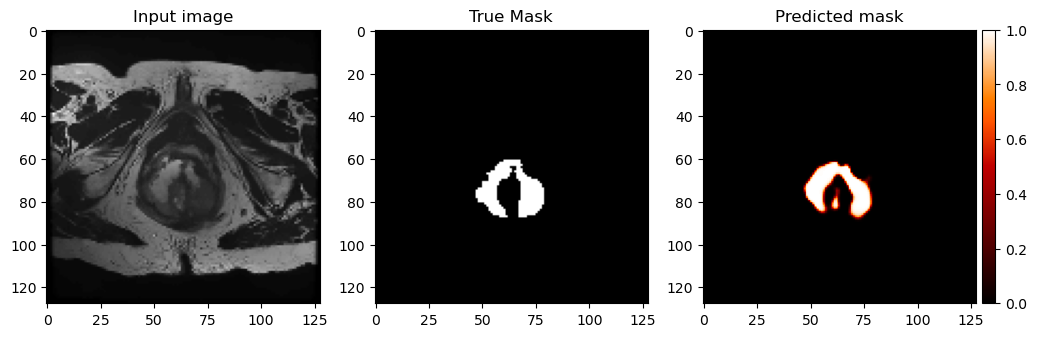

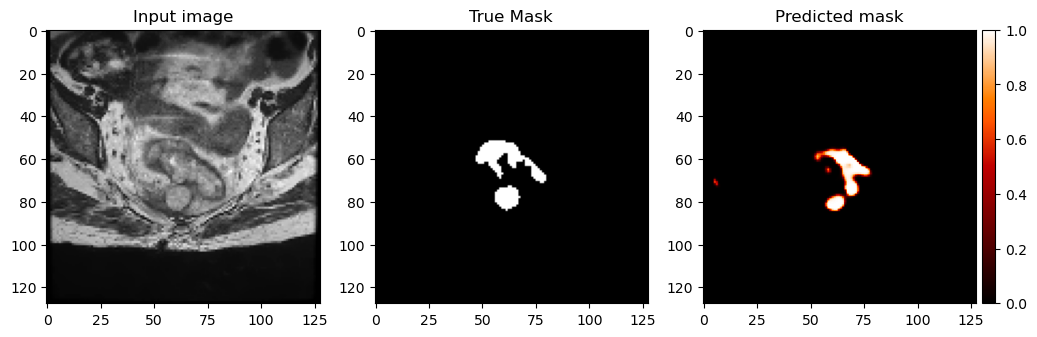

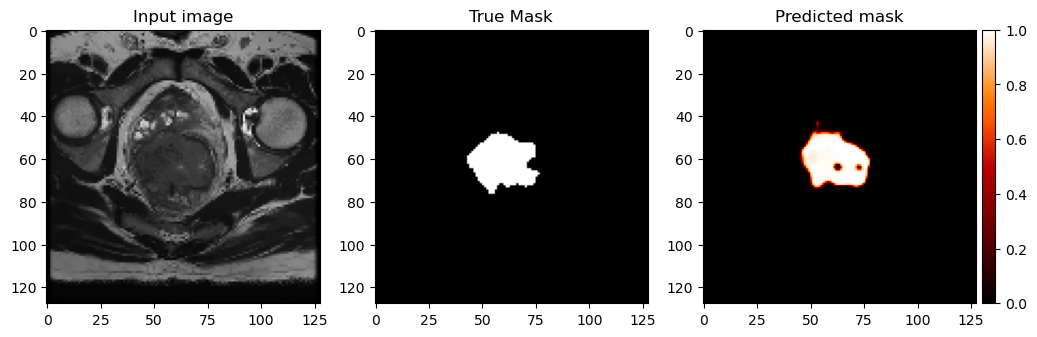

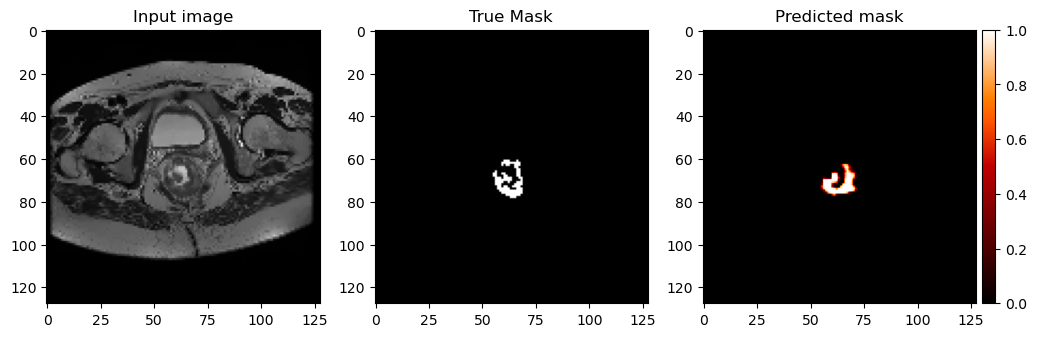

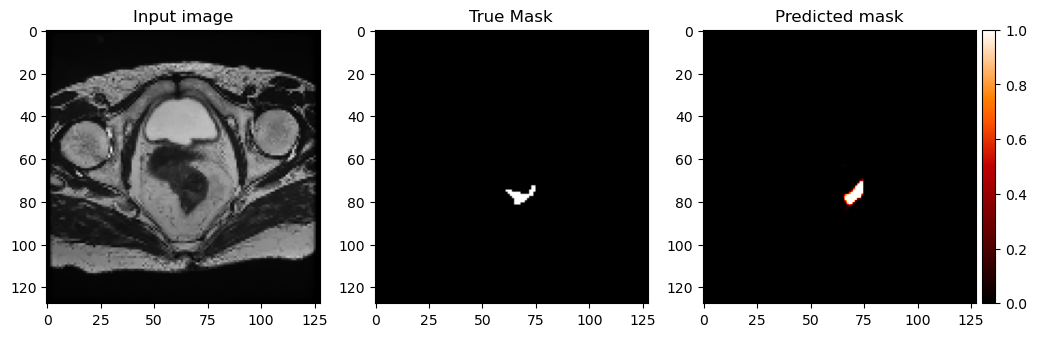

In [15]:
show_prediction(datagen=validation_generator, model=model , num=15)